In [1]:
from os import environ, path
import glob
from astropy import time
import numpy as np
from IPython import display
import pandas as pd
import panel as pn
pn.extension("tabulator")
import hvplot.pandas
import holoviews as hv
from dateutil.parser import parse 

import casacore.tables
from lwautils import lwa_arx
from lwautils import TimeoutException
from lwa_antpos import reading, mapping, lwa_df
from mnc import mcs, common, control
import dsautils.cnf as cnf
from dsautils import dsa_store
from lwa352_pipeline_control import Lwa352PipelineControl, Lwa352CorrelatorControl

ls = dsa_store.DsaStore()

Read antpos from xlsx file in repo


2023-05-25 16:54:13,271 - dsaStore - INFO - {"mjd": 60089.70432026195, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_host", "level": "info", "time": "2023-05-25T16:54:13.270603Z", "msg": "TODO: implement"}
2023-05-25 16:54:13,273 - dsaStore - INFO - {"mjd": 60089.70432029352, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "_check_port", "level": "info", "time": "2023-05-25T16:54:13.273353Z", "msg": "TODO: implement"}
2023-05-25 16:54:13,276 - dsaStore - INFO - {"mjd": 60089.7043203222, "proj": "dsa", "subsystem": "System", "app": "_", "version": "_", "module": "dsaStore", "function": "c-tor", "level": "info", "time": "2023-05-25T16:54:13.275831Z", "msg": "DsaStore created"}


## Set up

In [2]:
dd_statuses = []
con = control.Controller(f"{environ['HOME']}/proj/lwa-shell/mnc_python/config/lwa_config_calim.yaml")
adrs = con.conf['arx']['adrs']
npipeline = con.conf['xengines']['nxpipeline']

# get recorders and convert 'drvs/f' into full set of recorders
recorders = con.conf['dr']['recorders'].copy()
if 'drvs' in recorders:
    recorders.remove('drvs')
    for num in con.drvnums[::2]:  # one per pair
        recorders.append('drvs'+str(num))

if 'drvf' in recorders:
    recorders.remove('drvf')
    for num in con.drvnums[::2]:  # one per pair
        recorders.append('drvf'+str(num))

def most_recent_bcal(directory):
    # Get a list of all files in the directory
    # Partly written by ChatGPT

    files = glob.glob(path.join(directory, '*.bcal'))

    # Sort the files by creation time (oldest to newest)
    files.sort(key=lambda x: path.getctime(path.join(directory, x)))

    # Return the last (most recent) file in the list
    return path.join(directory, files[-1])

2023-05-25 16:54:14,372 - mnc.control.Lwa352CorrelatorControl - ERROR - host lxdlwagpu03 (pipeline None) failed to respond to etcd command!
2023-05-25 16:54:14,374 - mnc.control.Lwa352CorrelatorControl - ERROR - Control interface on host lxdlwagpu03 failed to respond to ping!
2023-05-25 16:54:14,376 - mnc.control.Lwa352CorrelatorControl - ERROR - lxdlwagpu03 pipeline 0 was unresponsive and will be ignored
Exception in thread etcd3_watch_7f24140dc470:
Traceback (most recent call last):
  File "/opt/devel/pipeline/envs/development/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/devel/pipeline/envs/development/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/devel/pipeline/envs/development/lib/python3.6/site-packages/etcd3/watch.py", line 126, in _run
    metadata=self._metadata)
  File "/opt/devel/pipeline/envs/development/lib/python3.6/site-packages/grpc/_channel.py", line 1209, in __call__
  

## cnf

In [3]:
#df_cnf_read = reading.read_antpos_etcd()
df_cnf_read = reading.read_antpos_xlsx()
df_cnf = df_cnf_read[['snap2_hostname', 'snap2_chassis', 'snap2_location', 'pola_digitizer_channel',
                      'polb_digitizer_channel', 'arx_address', 'pola_arx_channel', 'polb_arx_channel',
                      'pola_fee', 'polb_fee', 'corr_num']]
df_cnf_pane = pn.widgets.Tabulator(df_cnf, layout='fit_data_table', pagination='remote', page_size=20)

## Build table functions

In [4]:
# arx table build function
def build_a():
    ma = lwa_arx.ARX()
    arxcfg = []

    for adr in adrs:
        try:
            dds = ma.get_all_chan_cfg(adr)
        except:
            continue
        for ch, dd in enumerate(dds):
            dd['adr-ch'] = f'{adr}-{ch}'
            arxcfg.append(dd)
        dd_astatus = {'name': f'arx{adr}', 'mp_age': 0, 'ready': dd['sig_on']}
        dd_statuses.append(dd_astatus)

    df_arx = pd.DataFrame.from_dict(arxcfg)
    if any(df_arx):
        df_arx.set_index('adr-ch', inplace=True)

    df_a_pane = pn.widgets.Tabulator(df_arx, layout='fit_data_table', pagination='remote',
                                     width=900, page_size=20)
    return df_a_pane


# f-engine table build function
def build_f():
    global con
    dd_fs = []
    t_now = time.Time.now().unix
    try:
        _, stats = con.status_fengine()
    except Exception as e:
        del con
        return pn.panel(f'{e}')

    snap2names = con.conf['fengines']['snap2s_inuse']
    for snap2name in snap2names:
        t_now = time.Time.now().unix
        st = stats[snap2name]['fpga']
        timestamp = time.Time(st['timestamp'])

        if snap2name not in stats:
            continue
        else:
            dd_fstatus = {'name': snap2name, 'age (s)': t_now-timestamp.unix,
                          'ready': stats[snap2name]['fpga']['programmed']}

        dd_statuses.append(dd_fstatus)

        plot_fstats = None

        dd_f = {'name': snap2name}
        dd_f['age (s)'] = int(t_now-timestamp.unix)
#    dd_f['is_connected'] = lwa_feng.is_connected()  # can SNAP be reached with ping on network?
#    dd_f['is_polling'] = lwa_fe.is_polling()   # is monitor service checking on SNAP?
        dd_f['prog\'d?'] = st['programmed']
        dd_f['clk MHz'] = f"{st['fpga_clk_mhz']:.1f}"
        dd_f['gbps'] = f"{stats[snap2name]['eth']['gbps']:.1f}"

        st = stats[snap2name]['corr']
        dd_f['corr_acc_len'] = st['acc_len']

        st = stats[snap2name]['eqtvg']
        dd_f['test vector'] = st['tvg_enabled']
        
        dd_f['firmware'] = stats[snap2name]['fpga']['flash_firmware']
        
        st = stats[snap2name]['pfb']
        dd_f['overflow_count'] = st['overflow_count']

        st = stats[snap2name]['eq']
        dd_f['clip_count'] = st['clip_count']

        dd_fs.append(dd_f)

    df_f = pd.DataFrame.from_dict(dd_fs)
    if any(df_f):
        df_f.set_index('name', inplace=True)
        
    df_f_pane = pn.widgets.Tabulator(df_f, layout='fit_data_table', pagination='remote',
                                     width=1100, page_size=20)

    return df_f_pane


# TODO: f-engine stats plot build function
def build_fstats(snap2name):
    st = stats[snap2name]['input']
    pows = np.array([v for (k,v) in st.items() if 'pow' in k])
    means = np.array([v for (k,v) in st.items() if 'mean' in k])
    rms = np.array([v for (k,v) in st.items() if 'rms' in k])
#    snap_input = [f'{snap2name}-{k.strip("rms")}' for (k,v) in st.items() if 'rms' in k]
    df_fstats = pd.DataFrame(data={'pows': pows, 'mean': means, 'snap': len(pows)*[f'{snap2name}']})
    plot_fstats = df_fstats.hvplot.scatter('pows', 'mean', by='snap', width=700, title='F-engine stats')

    return plot_fstats


# x-engine table build function
def build_x():
    
    dd_xs = []
    t_now = time.Time.now().unix

    xhosts = con.conf['xengines']['xhosts']
    for host in xhosts:
        for pipeline in range(npipeline):
            name = f'{host}-{pipeline}'
            dd_x = {'name': name}
            try:
                lwa_x = Lwa352PipelineControl(pipeline_id=pipeline, etcdhost=common.ETCD_HOST, host=host)
            except Exception as e:
                dd_x['state']=str(e)
                dd_xs.append(dd_x)
                continue
            try:
                if lwa_x.pipeline_is_up():
                    st = lwa_x.corr.get_bifrost_status()
                    capture_st = lwa_x.capture.get_bifrost_status()
                    stats = st['stats']
                    t_now = time.Time.now().unix
                    dd_x['mp_age'] = t_now-st['time']
                    dd_x['state'] = stats['state']
    #                dd_xstatus = {'name': name}
    #                dd_xstatus['age (s)'] = int(t_now-st['time'])
                    dd_x['Corr gbps'] = st['gbps']
                    dd_x['Rx gbps'] = capture_st['gbps']
                    if len(st) > 1:
    #                    dd_xstatus['ready'] = stats['state'] == 'running'
                        if stats['state'] == 'running':
                            dd_x['curr_sample'] = stats['curr_sample']
    #                dd_statuses.append(dd_xstatus)
                else:
                    dd_x['state'] = 'Pipeline down.'
            except Exception as e:
                dd_x['state'] = str(e)
            dd_xs.append(dd_x)

    df_x = pd.DataFrame.from_dict(dd_xs)
    if any(df_x):
        df_x.set_index('name', inplace=True)

    df_x_pane = pn.widgets.Tabulator(df_x, layout='fit_data_table',
                                     width=1100)

    return df_x_pane


# Antenna table build function
def build_ant():
    
    tb = casacore.tables.table(most_recent_bcal('/home/pipeline/caltables/latest/'))
    flags = tb.getcol("FLAG")

# delays available like this:
#    _, stats = con.status_fengine()
#    delays = stats['snap02']['delay']

    ant_flags = [(mapping.correlator_to_antname(i),
                  i, 
                  lwa_df.loc[mapping.correlator_to_antname(i)].online,
                  ~flags[i].all())
                 for i in range(len(flags))]

    
    df_ant = pd.DataFrame(ant_flags, columns=['name', 'corr_num', 'online', 'MS unflagged'])
    df_ant.set_index('name', inplace=True)
    df_ant.sort_index(inplace=True)
    df_ant_pane = pn.widgets.Tabulator(df_ant, layout='fit_data_table', pagination='remote',
                                 width=900, page_size=20)
    return df_ant_pane


# Data recorder table build function
def build_dr():
    dd_ds = []
    t_now = time.Time.now().unix

    def val(monitor_point):
        return monitor_point.value if monitor_point else np.nan
    
    for drid in recorders:
        dd_d = {'name': drid}
        try:
            lwa_dr = mcs.Client(drid)
        except Exception as e:
            dd_d['info'] = f'INTERNAL ERROR: {e}'
            dd_ds.append(dd_d)
            continue
        try:
            summary = lwa_dr.read_monitor_point('summary')
            t_mp = summary.timestamp

            rx_rate = val(lwa_dr.read_monitor_point('bifrost/rx_rate'))/1e6
            rx_missing = val(lwa_dr.read_monitor_point('bifrost/rx_missing'))
            pipeline_lag = val(lwa_dr.read_monitor_point('bifrost/pipeline_lag'))
            tbfree = val(lwa_dr.read_monitor_point('storage/active_disk_free'))/1e12
            activedir = val(lwa_dr.read_monitor_point('storage/active_directory'))

            status = val(summary) + ', ' + str(val(lwa_dr.read_monitor_point('op-type')))
            info = val(lwa_dr.read_monitor_point('info'))
            dd_d.update({'age (s)': int(t_now-t_mp), 'receive mbps': int(rx_rate),
                         'Missing fraction': f'{(rx_missing*100):.1f}%',
                    'pipeline_lag (s)': pipeline_lag,
                    'Disk free (TB)': f'{tbfree:.1f}', 'Active dir': activedir,
                    'status': status, 'info': info})
        except Exception as e:
            dd_d['info'] = f'INTERNAL ERROR: {e}'
        dd_ds.append(dd_d)

    df_d = pd.DataFrame.from_dict(dd_ds)
    if any(df_d):
        df_d.set_index('name', inplace=True)

    df_d_pane = pn.widgets.Tabulator(df_d, layout='fit_data_table', pagination='remote',
                                     width=1100, page_size=20)

    return df_d_pane


def build_plot(antnum):
    if isinstance(antnum, int) and antnum > 0:
        plot_pane = pn.pane.JPG(f'/data10/pipeline/RFIMonitorData/plots/{antnum:03}.jpg', width=700)
    else:
        plot_pane = f'No f-eng summary plot for {antnum}'

    return plot_pane


def build_drvbl(drname):
    if drname not in ['drvs'+str(num) for num in con.drvnums]:
        pane_baselines = f'No plot available for {drname}'
    else:
        cl = mcs.Client(drname)
        data_baselines = cl.read_monitor_point('diagnostics/baselines')
        if data_baselines is not None:
            pane_baselines = pn.pane.PNG(display.Image(mcs.ImageMonitorPoint._decode_image_data(data_baselines.value)),
                                        width=700)
        else:
            pane_baselines = f'No plot available for {drname}'
    return pane_baselines

def build_drvim(drname):
    if drname not in ['drvs'+str(num) for num in con.drvnums]:
        pane_image = f'No image available for {drname}'
    else:
        cl = mcs.Client(drname)
        data_image = cl.read_monitor_point('diagnostics/image')
        if data_image is not None:
            pane_image = pn.pane.PNG(display.Image(mcs.ImageMonitorPoint._decode_image_data(data_image.value)),
                                                   width=700)
        else:
            pane_image = f'No image available for {drname}'
    return pane_image

def build_data(drname):
    pane_baselines = build_drvbl(drname)
    pane_image = build_drvim(drname)
    col = pn.Column(pane_image, pane_baselines)

    return col

In [5]:
#build_dr()
#df_arx_pane
#df_f_pane
#df_x_pane
#df_ant_pane
#df_d_pane
#pane_baselines
#pane_image

In [6]:
#df_status = pd.DataFrame.from_dict(dd_statuses)
#df_status.set_index('name', inplace=True)

### debugging up go/no-go

In [7]:
# or broken out:
#fpga.get_status()['is_programmed']
#fpga.get_status()['fpga_clk_mhz']
#eth.get_status()['gbps']

In [8]:
#status_a = []  # what is 'no-go' for an ARX channel/board?

In [9]:
t_stale = 120

In [10]:
status_f =  []
for snapnum in range(1, 12):
    status = ls.get_dict(f'/mon/snap/{snapnum:02}/status')
    t_age = time.Time.now().unix-time.Time(parse(status['timestamp'])).unix
    status_f.append((str(snapnum), (status['ok'] and t_age < t_stale)))

In [11]:
status_x = []
hostids = [f'{pp.host[-2:]}{pp.pipeline_id}' for pp in con.pipelines]
for host in con.xhosts:
#for pipeline in con.pipelines:
    for ii in range(con.npipeline):
        hostid = host[-2:] + str(ii)
        if hostid in hostids:
            pp = con.pipelines[hostids.index(hostid)]
            t_age = time.Time.now().unix-pp.capture.get_bifrost_status()['time']
            rate = pp.capture.get_bifrost_status()['gbps']
            status_x.append((hostid, (rate > 10 and t_age < t_stale)))
        else:
            status_x.append((hostid, False))

In [12]:
status_dr = []
for dr in recorders:
    summary = mcs.Client(dr).read_monitor_point('summary')
    t_age = time.Time.now().unix-summary.timestamp
    status_dr.append((dr.lstrip('dr'), (summary.value == 'normal' and t_age < t_stale)))

In [13]:
statuses = ['red', 'green']
width = 25
label_row = pn.Row(pn.pane.HTML('Go/No-Go: F-eng, X-eng, DR', style={'padding': '10px', 'border':'2px solid black'}))
f_row = pn.Row(*[pn.pane.HTML(name, width=int(900/len(status_f)), align='center', height=width, margin=1, background=statuses[st]) for name, st in status_f])
x_row = pn.Row(*[pn.pane.HTML(name, width=int(900/len(status_x)), align='center', height=width, margin=1, background=statuses[st]) for name, st in status_x])
dr_row = pn.Row(*[pn.pane.HTML(name, width=int(900/len(status_dr)), align='center', height=width, margin=1, background=statuses[st]) for name, st in status_dr])

pane_gonogo = pn.Column(label_row, f_row, x_row, dr_row)

/opt/devel/pipeline/envs/development/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  after removing the cwd from sys.path.
/opt/devel/pipeline/envs/development/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  """
/opt/devel/pipeline/envs/development/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


In [14]:
#pane_gonogo

In [15]:
# make pane to show low-freq-sky web app
pane_lfs = pn.pane.HTML("<iframe src='http://localhost:8081', height=700, width=900>")

## Build dashboard

In [16]:
ant_filter = pn.widgets.IntInput(name='Select ant to display f-eng summary plot',
                                 placeholder='1,2,3,4,5,6,7,8,9,10,...,352', value=1)
dr_filter = pn.widgets.Select(name='Select data recorder to display data',
                              options=sorted(list(set(['drvs'+str(num) for num in con.drvnums]))))

pant = pn.param.ParamFunction(build_ant, lazy=True)
pa = pn.param.ParamFunction(build_a, lazy=True)
pf = pn.param.ParamFunction(build_f, lazy=True)
px = pn.param.ParamFunction(build_x, lazy=True)
pdr = pn.param.ParamFunction(build_dr, lazy=True)

In [17]:
dashboard_title = pn.panel('## OVRO-LWA System Health Dashboard')
tabs = pn.Tabs(('Cabling', df_cnf_pane),
               ('Antennas', pant),
               ('ARX', pa),
               ('F-engine', pf),
               ('X-engine', px),
               ('Data recorder', pdr),
               dynamic=True, active=5)

header_f = pn.pane.Markdown('##Data', width=700)
plot_spec_pane = pn.Column(pn.Column(ant_filter), pn.panel(pn.bind(build_plot, ant_filter)), width=700)
pane_data = pn.Column(dr_filter, pn.panel(pn.bind(build_data, dr_filter)), width=700)
mini_dashboard = pn.Column(dashboard_title, pane_gonogo, tabs, header_f, pane_data, plot_spec_pane, pane_lfs, width=700)

Column(width=700)
    [0] Markdown(str)
    [1] Column
        [0] Row
            [0] HTML(str, style={'padding': '10px', ...})
        [1] Row
            [0] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=81)
            [1] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=81)
            [2] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=81)
            [3] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=81)
            [4] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=81)
            [5] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=81)
            [6] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=81)
            [7] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=81)
            [8] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=81)
            [9] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=81)
            [10] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=81)
        [2] Row
            [0] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [1] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [2] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [3] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [4] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [5] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [6] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [7] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [8] HTML(str, align='center', background='red', height=25, margin=1, sizing_mode='fixed', width=28)
            [9] HTML(str, align='center', background='red', height=25, margin=1, sizing_mode='fixed', width=28)
            [10] HTML(str, align='center', background='red', height=25, margin=1, sizing_mode='fixed', width=28)
            [11] HTML(str, align='center', background='red', height=25, margin=1, sizing_mode='fixed', width=28)
            [12] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [13] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [14] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [15] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [16] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [17] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [18] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [19] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [20] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [21] HTML(str, align='center', background='green', height=25, margin=1, sizing_mode='fixed', width=28)
            [22] HTML(str, align='center', background='green', height=25
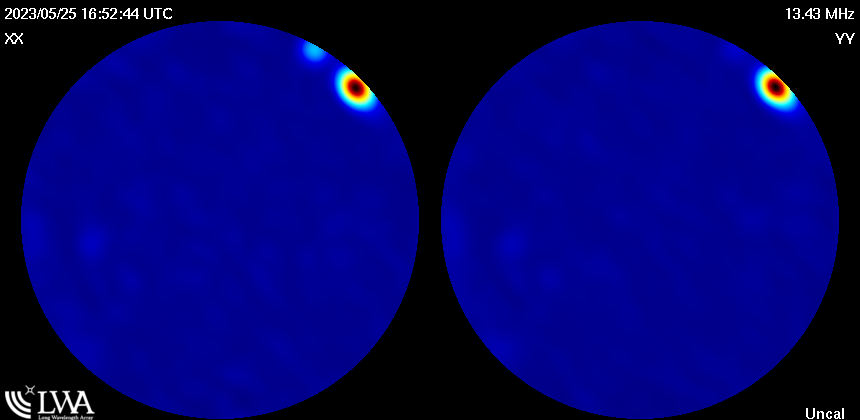
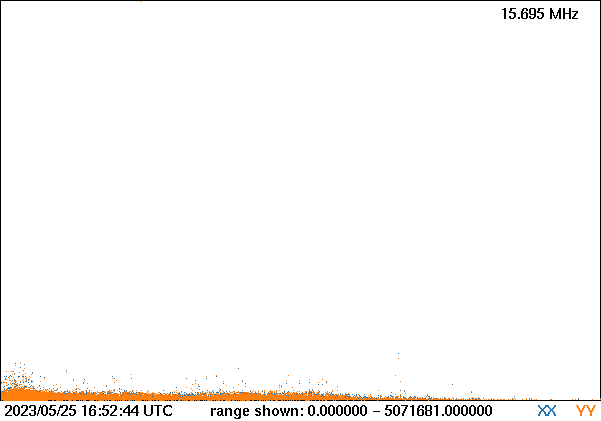
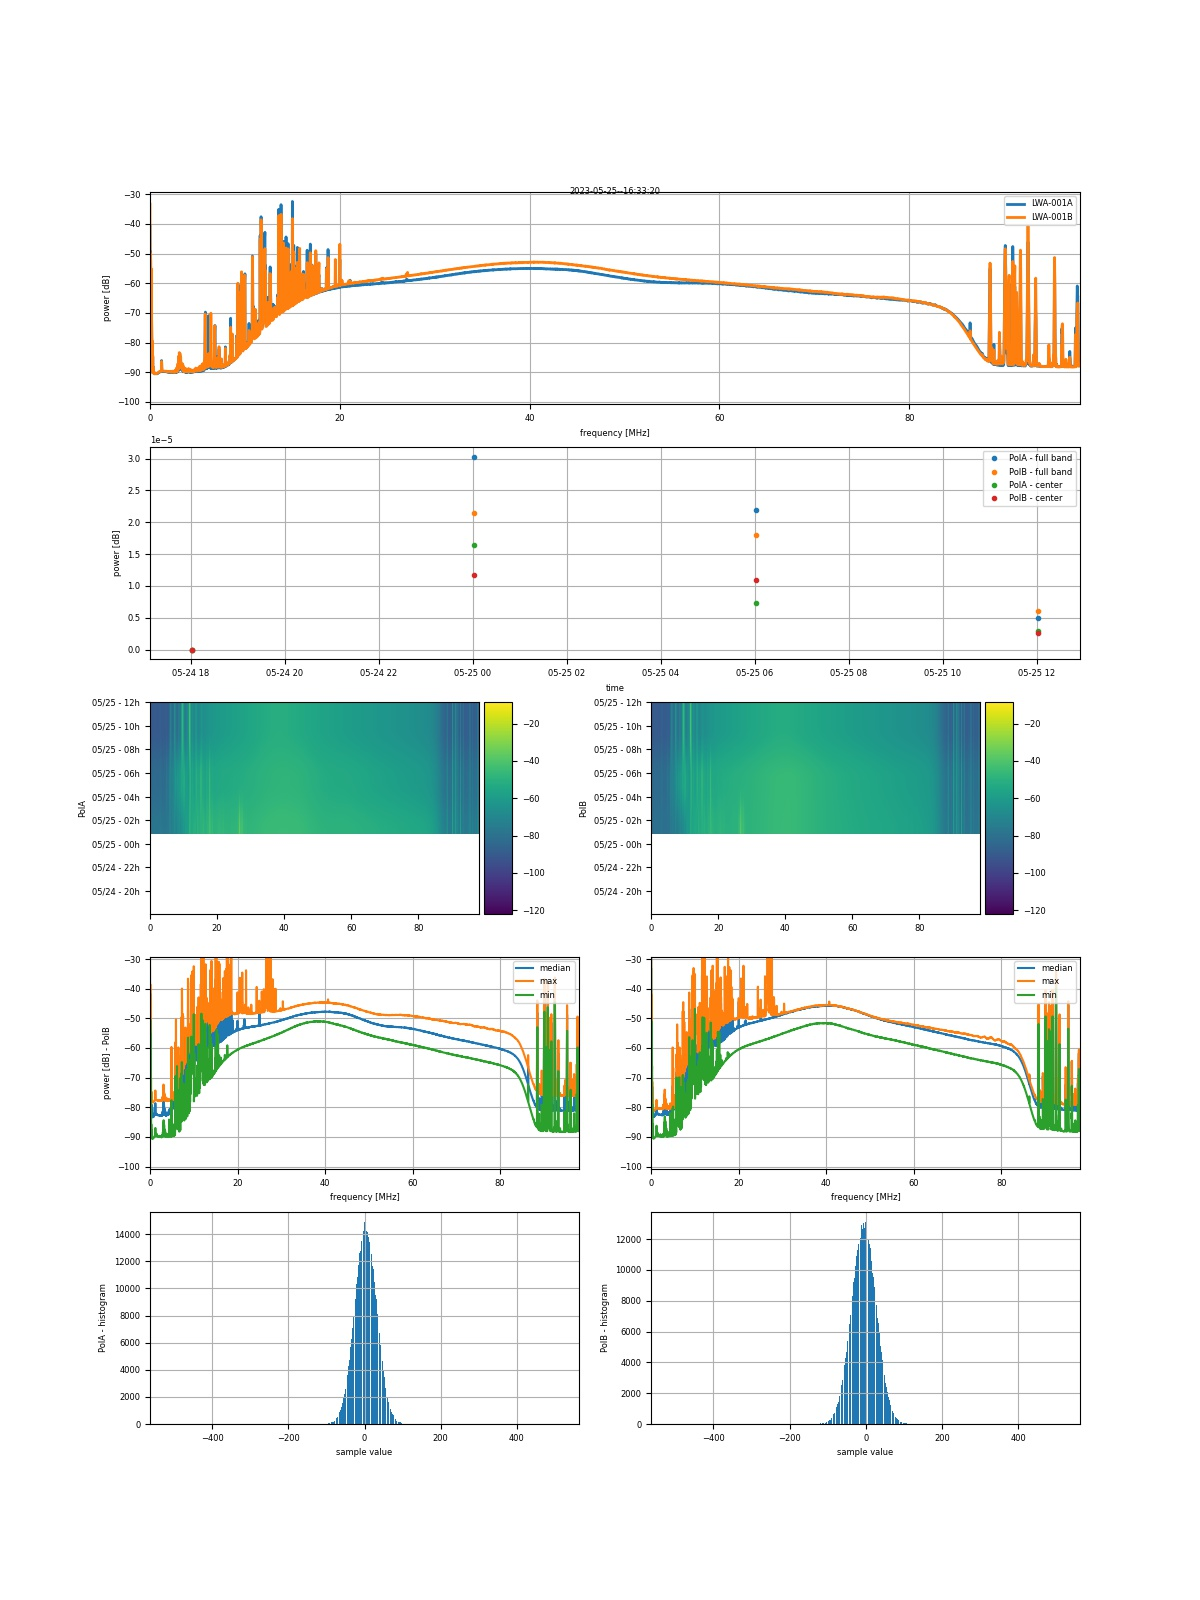

In [18]:
mini_dashboard.servable(title='OVRO-LWA dashboard')